In [1]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.
/Users/waihamyee/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# dimensions of our images.
img_width, img_height = 360, 257

train_data_dir = 'classes/train'
validation_data_dir = 'classes/validation'

In [3]:
nb_train_samples = 541
nb_validation_samples = 30
nb_epoch = 50

In [4]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, img_width, img_height)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# this is the augmentation configuration we will use for training
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

img = load_img('classes/train/jordans/1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print x.shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='train', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=10,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=10,
        class_mode='binary')

Found 1891 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [21]:
# Train the network
model.fit_generator(
        train_generator,
        samples_per_epoch=541,
        nb_epoch=10,
        validation_data=validation_generator,
        nb_val_samples=800)
print "Done!!"

model.save_weights('first_try_1.h5')

Epoch 1/10
540/541 [============================>.] - ETA: 1s - loss: 0.7967 - acc: 0.6907 

/Users/waihamyee/anaconda/lib/python2.7/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


550/541 [==============================] - 1017s - loss: 0.7897 - acc: 0.6945 - val_loss: 1.2679 - val_acc: 0.5013
Epoch 2/10
550/541 [==============================] - 2025s - loss: 0.7297 - acc: 0.6855 - val_loss: 0.7946 - val_acc: 0.5013
Epoch 3/10
550/541 [==============================] - 1006s - loss: 0.5935 - acc: 0.7236 - val_loss: 0.7298 - val_acc: 0.5013
Epoch 4/10
541/541 [==============================] - 1009s - loss: 0.5620 - acc: 0.7375 - val_loss: 0.5918 - val_acc: 0.6325
Epoch 5/10
550/541 [==============================] - 1123s - loss: 0.5662 - acc: 0.7345 - val_loss: 0.6247 - val_acc: 0.5688
Epoch 6/10
550/541 [==============================] - 1045s - loss: 0.5766 - acc: 0.7109 - val_loss: 0.5786 - val_acc: 0.6000
Epoch 7/10
541/541 [==============================] - 1049s - loss: 0.6052 - acc: 0.7227 - val_loss: 0.5580 - val_acc: 0.6513
Epoch 8/10
550/541 [==============================] - 1161s - loss: 0.5404 - acc: 0.7636 - val_loss: 0.6129 - val_acc: 0.6350
Epo

In [35]:
i = 0
for batch in test_datagen.flow(x, batch_size=20,
                  save_to_dir='preview', save_prefix='train', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

(3, 257, 360)
257
360
(255.0, 255.0, 255.0)
(257, 360)
(257, 360)
(257, 360)


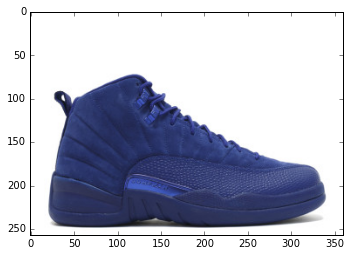

In [122]:
img = load_img('classes/train/jordans/1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)

print x.shape
print len(x[0])
print len(x[0][0])
print (x[0][0][0],x[1][0][0],x[2][0][0])
print x[0].shape
print x[1].shape
print x[2].shape

x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
plt.imshow(img, cmap=cm.binary)


In [148]:
img = load_img('classes/train/jordans/1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        featurewise_std_normalization=True,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(28, 28),
        batch_size=5,
        save_to_dir='preview',
        save_prefix='train',
        save_format='jpeg',
        class_mode='binary')

x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='train', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


Found 1891 images belonging to 2 classes.


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'